<a href="https://colab.research.google.com/github/oshbocker/CAFA/blob/main/CAFA_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"oshbocker","key":"bb9c6a60ba5c39e689d8cf8d15cb8bca"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install obonet -q
!pip install biopython -q
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 32.3 MB/s eta 0:00:00


In [ ]:
import os
import torch

from pathlib import Path


iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

cafa_main_path = Path("cafa-5-protein-function-prediction")
cafa_clean_fasta_path = Path("viktorfairuschin/cafa-5-fasta-files")
esm2_path = Path("viktorfairuschin/cafa-5-ems-2-embeddings-numpy")
protbert_path = Path("henriupton/protbert-embeddings-for-cafa5")
t5_path = Path("sergeifironov/t5embeds")

data_paths = [cafa_clean_fasta_path, esm2_path, protbert_path, t5_path]

if iskaggle:
  content_dir = "/kaggle/input"
else:
  content_dir = "/content"

class CFG:
    train_go_obo_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/go-basic.obo"
    train_seq_fasta_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_sequences.fasta"
    train_terms_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_terms.tsv"
    train_taxonomy_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv"
    train_ia_path: str = f"{content_dir}/cafa-5-protein-function-prediction/IA.txt"
    test_sequences_path: str = f"{content_dir}/Test (Targets)/testsuperset.fasta"

    num_labels = 500
    n_epochs = 15
    batch_size = 128
    lr = 0.001

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
if not iskaggle:
  import zipfile,kaggle
  if not cafa_main_path.exists():
    print(cafa_main_path)
    kaggle.api.competition_download_cli(str(cafa_main_path))
    zipfile.ZipFile(f'{cafa_main_path}.zip').extractall(cafa_main_path)
  for data_path in data_paths:
    if not data_path.exists():
      print(data_path)
      kaggle.api.dataset_download_files(str(data_path))
      zipfile.ZipFile(f'{data_path.name}.zip').extractall(data_path.name)

cafa-5-protein-function-prediction


100%|██████████| 115M/115M [00:06<00:00, 19.5MB/s]



viktorfairuschin/cafa-5-fasta-files
viktorfairuschin/cafa-5-ems-2-embeddings-numpy
henriupton/protbert-embeddings-for-cafa5
sergeifironov/t5embeds


In [ ]:
import obonet
import time

import networkx as nx
import pandas as pd
import numpy as np
from Bio import SeqIO
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

In [ ]:
graph = obonet.read_obo(CFG.train_go_obo_path)

In [ ]:
# Information Accretion values for terms
ia_dict = {}
with open(CFG.train_ia_path) as f:
    for line in f:
        (key, value) = line.split("\t")
        ia_dict[key] = float(value.replace("\n",""))

In [ ]:
subontology_roots = {'BPO':'GO:0008150',
                     'CCO':'GO:0005575',
                     'MFO':'GO:0003674'}

BPO_len = len(nx.ancestors(graph, subontology_roots['BPO']))
CCO_len = len(nx.ancestors(graph, subontology_roots['CCO']))
MFO_len = len(nx.ancestors(graph, subontology_roots['MFO']))
print(BPO_len, CCO_len, MFO_len, BPO_len + CCO_len + MFO_len)

27941 4042 11262 43245


In [ ]:
train_terms = pd.read_csv(CFG.train_terms_path, sep="\t")
train_terms['ia'] = train_terms['term'].apply(lambda x: ia_dict[x])
print(train_terms.shape)
train_terms.head(10)

(5363863, 4)


,EntryID,term,aspect,ia
0,A0A009IHW8,GO:0008152,BPO,1.598544
1,A0A009IHW8,GO:0034655,BPO,0.042274
2,A0A009IHW8,GO:0072523,BPO,0.083901
3,A0A009IHW8,GO:0044270,BPO,0.281155
4,A0A009IHW8,GO:0006753,BPO,0.013844
5,A0A009IHW8,GO:1901292,BPO,0.000000
6,A0A009IHW8,GO:0044237,BPO,0.103670
7,A0A009IHW8,GO:1901360,BPO,1.237575
8,A0A009IHW8,GO:0008150,BPO,0.000000
9,A0A009IHW8,GO:1901564,BPO,0.557385


## Get the leaf predictions for each protein
A leaf prediction is a GO term that doesn't have any children that are also predictions for the protein.

In [ ]:
def get_leaf_labels(train_terms, aspect):
    # Group by protein and get a list of all go term predictions
    protein_list_go_term = train_terms[train_terms['aspect'] == aspect].groupby('EntryID')['term'].apply(list)

    leaf_labels = {}
    for i, protein in enumerate(protein_list_go_term.index):
        test_terms = set(protein_list_go_term[protein])
        descendants = set()
        for term in test_terms:
            descendants.update(nx.descendants(graph, term))

        specific_labels = test_terms.difference(descendants)
        leaf_labels[protein] = list(specific_labels)

    return leaf_labels

from collections import deque

# Get ordered list of all ancestors
def leaf_label_ancestors(graph, leaf_labels):
    ordered_edges_dict = {}
    for label in leaf_labels:
        # Get ancestors
        ordered_edges = deque()
        node_is_root = False
        prev_node_id = label
        while node_is_root == False:
            node = graph.nodes[prev_node_id]
            node_is_root = 'is_a' not in node
            if not node_is_root:
                prev_node_id = node['is_a'][0]
                ordered_edges.appendleft(prev_node_id)
        ordered_edges_dict[label] = ordered_edges

    return ordered_edges_dict

In [ ]:
CCO_leaf_labels = get_leaf_labels(train_terms, 'CCO')
print(len(CCO_leaf_labels.values()))
CCO_all_leaf_labels = np.unique(np.concatenate(list(CCO_leaf_labels.values())))
print(len(CCO_all_leaf_labels))
CCO_ordered_edges = leaf_label_ancestors(graph, CCO_all_leaf_labels)

92912
2763


In [ ]:
# Get the first node label
data_with_labels = []
# Get all CCO labeled proteins with leaf labels
for protein, label_list in CCO_leaf_labels.items():
    for label in label_list:
        data_with_labels.append({'protein': protein,
                                 'label': label,
                                 'ordered_edges': CCO_ordered_edges[label]})

In [ ]:
def get_next_label(rw, depth=1):
    if not rw['labeled'] and len(rw['ordered_edges']) > depth:
        return rw['ordered_edges'][-depth]
    else:
        return rw['balanced_label']

def is_final_balanced_label(rw, balanced_labels, depth=1):
    if not rw['labeled']:
        return (rw['balanced_label'] in balanced_labels) or (len(rw['ordered_edges']) == depth)
    else:
        return True

def get_balanced_labels(label_df, label_count_threshold):
    df = label_df.copy()
    balanced_labels = set([label for label, count in df['label'].value_counts().items()
                           if count >= label_count_threshold])
    df['labeled'] = df['label'].apply(lambda x: x in balanced_labels)
    df['balanced_label'] = df['label'] # df.apply(lambda x: x['label'] if x['labeled'] == True else None, axis=1)
    print(sum(df['labeled'])/df.shape[0])
    print(len(balanced_labels))
    print(df['balanced_label'].value_counts())
    depth = 1
    while sum(df['labeled'])/df.shape[0] < 1:
        df['balanced_label'] = df.apply(lambda x: get_next_label(x, depth=depth), axis=1)
        balanced_labels = set([label for label, count in df['balanced_label'].value_counts().items()
                                   if count >= label_count_threshold])
        df['labeled'] = df.apply(lambda x: is_final_balanced_label(x, balanced_labels, depth=depth), axis=1)
        depth += 1
        print(sum(df['labeled'])/df.shape[0])
        print(len(balanced_labels))
        print(df['balanced_label'].value_counts())

    return df

In [ ]:
CCO_df = pd.DataFrame(data_with_labels)

new_CCO_df = get_balanced_labels(CCO_df, 1358)

0.46988094968653105
14
GO:0005829    16981
GO:0005634    12661
GO:0005886    11509
GO:0005737     8335
GO:0005654     8160
              ...  
GO:1990332        1
GO:0009316        1
GO:0099571        1
GO:0044186        1
GO:0071202        1
Name: balanced_label, Length: 2763, dtype: int64
0.6748296856256931
26
GO:0005829    16981
GO:0110165    12989
GO:0005634    12725
GO:0005886    11823
GO:0005737     8932
              ...  
GO:0032160        1
GO:0055035        1
GO:0031002        1
GO:0030929        1
GO:0098539        1
Name: balanced_label, Length: 678, dtype: int64
0.8399723875698798
29
GO:0110165    21336
GO:0005829    17050
GO:0005634    12910
GO:0005886    11823
GO:0005737     8948
              ...  
GO:0099572        1
GO:0033176        1
GO:0097518        1
GO:0005788        1
GO:0042170        1
Name: balanced_label, Length: 272, dtype: int64
0.9202521331733925
29
GO:0110165    25516
GO:0005829    17050
GO:0005634    12938
GO:0005886    11823
GO:0032991    10919
      

## Classify selected nodes of CCO

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
ohe_CCO_df = pd.get_dummies(new_CCO_df, prefix=['balanced_label'], columns=['balanced_label'], drop_first=True)
label_cols = [c for c in ohe_CCO_df.columns if 'balanced_label_' in c]
label_df = ohe_CCO_df.groupby('protein').sum(numeric_only=True)[label_cols].clip(0,1)
label_values = list(label_df.values)
label_ids = list(label_df.index)
labels_df = pd.DataFrame(data={"EntryID": label_ids, "labels_vect": label_values})

# Split into train, val, test
X_train, X_test, y_train, y_test = train_test_split(label_ids,
                                                    label_values,
                                                    test_size = 0.2)
print("Train label", len(y_train))
print("Test label", len(y_test))

Train label 74329
Test label 18583


In [ ]:
# Directories for the different embedding vectors :
embeds_map = {
    "T5" : "t5embeds",
    "ProtBERT" : "protbert-embeddings-for-cafa5",
    "ESM2" : "cafa-5-ems-2-embeddings-numpy"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024,
    "ProtBERT" : 1024,
    "ESM2" : 1280,
    "Concat": 1024+1024,
}

In [ ]:
class ProteinSequenceDataset(Dataset):

    def __init__(self, datatype, embeddings_source):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype

        if embeddings_source in ["ProtBERT", "ESM2"]:
            embeds = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
            ids = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")

        if embeddings_source == "T5":
            embeds = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_embeds.npy")
            ids = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")

        if embeddings_source == "Concat":
            bert_embeds = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_embeddings.npy")
            bert_ids = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_ids.npy")
            esm2_embeds = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_embeddings.npy")
            esm2_ids = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_ids.npy")
            t5_embeds = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_embeds.npy")
            t5_ids = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_ids.npy")
            embeds = np.concatenate([bert_embeds, t5_embeds], axis=1)
            embeds_list = []
            for l in range(embeds.shape[0]):
                embeds_list.append(embeds[l,:])
            self.df = pd.DataFrame(data={"EntryID": t5_ids, "embed" : embeds_list})
        else:
            embeds_list = []
            for l in range(embeds.shape[0]):
                embeds_list.append(embeds[l,:])
            self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})


        if datatype=="train":
            self.df = self.df.merge(labels_df, on="EntryID")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id

In [ ]:
datatype = "train"
bert_embeds = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_embeddings.npy")
bert_ids = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_ids.npy")
esm2_embeds = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_embeddings.npy")
esm2_ids = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_ids.npy")
t5_embeds = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_embeds.npy")
t5_ids = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_ids.npy")

In [ ]:
bert_embeds.shape

(142246, 1024)

In [ ]:
np.concatenate([bert_embeds, t5_embeds], axis=1).shape

(142246, 2048)

In [ ]:
print(bert_ids[:5])
print(esm2_ids[:5])
print(t5_ids[:5])

['P20536' 'O73864' 'O95231' 'A0A0B4J1F4' 'P54366']
['Q9ZSA8' 'P25353' 'A0A2R8YCW8' 'G3V5N8' 'A0A140LFN4']
['P20536' 'O73864' 'O95231' 'A0A0B4J1F4' 'P54366']


In [ ]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, 4*1012)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(4*1012, 4*712)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(4*712, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x


class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        # (batch_size, channels, embed_size)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 3, embed_size)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 3, embed_size/2 = 512)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 8, embed_size/2 = 512)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 8, embed_size/4 = 256)
        self.fc1 = nn.Linear(in_features=int(8 * input_dim/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def train_model(embeddings_source, model_type="linear", train_size=0.9):

    train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = embeddings_source)

    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=CFG.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=CFG.batch_size, shuffle=True)

    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=CFG.num_labels).to(CFG.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=embeds_dim[embeddings_source], num_classes=CFG.num_labels).to(CFG.device)

    optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=CFG.num_labels).to(CFG.device)
    n_epochs = CFG.n_epochs

    print("BEGIN TRAINING...")
    train_loss_history=[]
    val_loss_history=[]

    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(CFG.device), targets.to(CFG.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)

        ## VALIDATION PHASE :
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(CFG.device), targets.to(CFG.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)

        scheduler.step(avg_loss)
        print("\n")

    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])

    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}

    return model, losses_history, scores_history

In [ ]:
train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = "ESM2")
CFG.num_labels = train_dataset[0][1].shape[0]

In [ ]:
cat_model, cat_losses,cat_scores = train_model(embeddings_source="Concat",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:17<00:00, 38.17it/s]


Running Average TRAIN Loss :  4.315488024224564
Running Average TRAIN F1-Score :  0.18549620538995537
Running Average VAL Loss :  4.100779030421009
Running Average VAL F1-Score :  0.20886010360227872


EPOCH  2


100%|██████████| 654/654 [00:13<00:00, 48.18it/s]


Running Average TRAIN Loss :  4.035869933778722
Running Average TRAIN F1-Score :  0.22356877391673738
Running Average VAL Loss :  3.976151949738803
Running Average VAL F1-Score :  0.22650790826915063


EPOCH  3


100%|██████████| 654/654 [00:13<00:00, 47.42it/s]


Running Average TRAIN Loss :  3.9223883738940644
Running Average TRAIN F1-Score :  0.24003777687155872
Running Average VAL Loss :  3.956378077807492
Running Average VAL F1-Score :  0.23931847961798106


EPOCH  4


100%|██████████| 654/654 [00:13<00:00, 47.42it/s]


Running Average TRAIN Loss :  3.82887301167946
Running Average TRAIN F1-Score :  0.2519227086085063
Running Average VAL Loss :  3.883125024299099
Running Average VAL F1-Score :  0.245709214104365


EPOCH  5


100%|██████████| 654/654 [00:13<00:00, 48.06it/s]


Running Average TRAIN Loss :  3.7357054095749462
Running Average TRAIN F1-Score :  0.2642325479822057
Running Average VAL Loss :  3.869270229992801
Running Average VAL F1-Score :  0.25585084969866767


EPOCH  6


100%|██████████| 654/654 [00:13<00:00, 47.94it/s]


Running Average TRAIN Loss :  3.650926031468476
Running Average TRAIN F1-Score :  0.27694036852602566
Running Average VAL Loss :  3.846980725249199
Running Average VAL F1-Score :  0.26526422227082186


EPOCH  7


100%|██████████| 654/654 [00:13<00:00, 48.49it/s]


Running Average TRAIN Loss :  3.5568492933879936
Running Average TRAIN F1-Score :  0.2885459186195963
Running Average VAL Loss :  3.84621954617435
Running Average VAL F1-Score :  0.27546167067468985


EPOCH  8


100%|██████████| 654/654 [00:13<00:00, 48.70it/s]


Running Average TRAIN Loss :  3.464714800910483
Running Average TRAIN F1-Score :  0.3009706376069183
Running Average VAL Loss :  3.8763263617476373
Running Average VAL F1-Score :  0.27861340731790624


EPOCH  9


100%|██████████| 654/654 [00:13<00:00, 48.72it/s]


Running Average TRAIN Loss :  3.3669154891909443
Running Average TRAIN F1-Score :  0.3139251946309291
Running Average VAL Loss :  3.873659130645125
Running Average VAL F1-Score :  0.28618625133004905


EPOCH  10


100%|██████████| 654/654 [00:13<00:00, 48.31it/s]


Running Average TRAIN Loss :  3.095746098308388
Running Average TRAIN F1-Score :  0.33513108982678946
Running Average VAL Loss :  3.837839025340668
Running Average VAL F1-Score :  0.29278323707515247


EPOCH  11


100%|██████████| 654/654 [00:13<00:00, 47.95it/s]


Running Average TRAIN Loss :  3.0280028825870713
Running Average TRAIN F1-Score :  0.34153383505453755
Running Average VAL Loss :  3.852166090926079
Running Average VAL F1-Score :  0.29302462282246106


EPOCH  12


100%|██████████| 654/654 [00:13<00:00, 48.09it/s]


Running Average TRAIN Loss :  2.9892482600809966
Running Average TRAIN F1-Score :  0.3470584573366591
Running Average VAL Loss :  3.8664325818623584
Running Average VAL F1-Score :  0.2944438098228141


EPOCH  13


100%|██████████| 654/654 [00:13<00:00, 48.53it/s]


Running Average TRAIN Loss :  2.939826480474676
Running Average TRAIN F1-Score :  0.3507586244140561
Running Average VAL Loss :  3.8733022964164
Running Average VAL F1-Score :  0.30078707512927383


EPOCH  14


100%|██████████| 654/654 [00:13<00:00, 47.97it/s]


Running Average TRAIN Loss :  2.9339361526185948
Running Average TRAIN F1-Score :  0.35114721489062
Running Average VAL Loss :  3.875210066364236
Running Average VAL F1-Score :  0.296996558569882


EPOCH  15


100%|██████████| 654/654 [00:13<00:00, 48.47it/s]


Running Average TRAIN Loss :  2.925733946149867
Running Average TRAIN F1-Score :  0.35364265594095995
Running Average VAL Loss :  3.8776844070382315
Running Average VAL F1-Score :  0.29977719424522087


TRAINING FINISHED
FINAL TRAINING SCORE :  0.35364265594095995
FINAL VALIDATION SCORE :  0.29977719424522087


TRAINING FINISHED
FINAL TRAINING SCORE :  0.31309230539047755
FINAL VALIDATION SCORE :  0.2773439412655896

In [ ]:
esm2_model, esm2_losses, esm2_scores = train_model(embeddings_source="ESM2",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:12<00:00, 52.86it/s]


Running Average TRAIN Loss :  4.297300809384851
Running Average TRAIN F1-Score :  0.192433990424197
Running Average VAL Loss :  4.158430034167146
Running Average VAL F1-Score :  0.2251039357626275


EPOCH  2


100%|██████████| 654/654 [00:12<00:00, 52.99it/s]


Running Average TRAIN Loss :  4.033070339704508
Running Average TRAIN F1-Score :  0.2278660665001344
Running Average VAL Loss :  4.058782734283029
Running Average VAL F1-Score :  0.24171098944259017


EPOCH  3


100%|██████████| 654/654 [00:12<00:00, 52.80it/s]


Running Average TRAIN Loss :  3.90673762869762
Running Average TRAIN F1-Score :  0.24547817708428846
Running Average VAL Loss :  4.01819636070565
Running Average VAL F1-Score :  0.24840608749487628


EPOCH  4


100%|██████████| 654/654 [00:12<00:00, 53.29it/s]


Running Average TRAIN Loss :  3.7890864340901738
Running Average TRAIN F1-Score :  0.2605803199909878
Running Average VAL Loss :  3.9722189021437138
Running Average VAL F1-Score :  0.2590155191209218


EPOCH  5


100%|██████████| 654/654 [00:12<00:00, 52.66it/s]


Running Average TRAIN Loss :  3.664055688300993
Running Average TRAIN F1-Score :  0.27716229211208654
Running Average VAL Loss :  3.9458386832720613
Running Average VAL F1-Score :  0.26947180049060143


EPOCH  6


100%|██████████| 654/654 [00:12<00:00, 52.97it/s]


Running Average TRAIN Loss :  3.538788051051102
Running Average TRAIN F1-Score :  0.2935044600967238
Running Average VAL Loss :  3.9348738095531726
Running Average VAL F1-Score :  0.27624034922416896


EPOCH  7


100%|██████████| 654/654 [00:12<00:00, 52.77it/s]


Running Average TRAIN Loss :  3.4088381904345404
Running Average TRAIN F1-Score :  0.3118103710473131
Running Average VAL Loss :  3.9413191553664535
Running Average VAL F1-Score :  0.28379826431405053


EPOCH  8


100%|██████████| 654/654 [00:12<00:00, 53.04it/s]


Running Average TRAIN Loss :  3.271804871544561
Running Average TRAIN F1-Score :  0.328990220932421
Running Average VAL Loss :  3.9674613835060435
Running Average VAL F1-Score :  0.29343209058454595


EPOCH  9


100%|██████████| 654/654 [00:12<00:00, 52.78it/s]


Running Average TRAIN Loss :  2.9285059718910706
Running Average TRAIN F1-Score :  0.36121760805447894
Running Average VAL Loss :  3.9320596538177908
Running Average VAL F1-Score :  0.2989302346967671


EPOCH  10


100%|██████████| 654/654 [00:12<00:00, 53.18it/s]


Running Average TRAIN Loss :  2.833981225067687
Running Average TRAIN F1-Score :  0.36980632034099065
Running Average VAL Loss :  3.960478723865666
Running Average VAL F1-Score :  0.30295581850287034


EPOCH  11


100%|██████████| 654/654 [00:12<00:00, 52.81it/s]


Running Average TRAIN Loss :  2.7824907202603986
Running Average TRAIN F1-Score :  0.3774936328149352
Running Average VAL Loss :  3.9763525414140255
Running Average VAL F1-Score :  0.3077090374410969


EPOCH  12


100%|██████████| 654/654 [00:12<00:00, 53.20it/s]


Running Average TRAIN Loss :  2.7161314844720588
Running Average TRAIN F1-Score :  0.38464518128367375
Running Average VAL Loss :  3.976350193154322
Running Average VAL F1-Score :  0.30725436096322045


EPOCH  13


100%|██████████| 654/654 [00:12<00:00, 53.04it/s]


Running Average TRAIN Loss :  2.708284237698313
Running Average TRAIN F1-Score :  0.3848175447012671
Running Average VAL Loss :  3.980245479165691
Running Average VAL F1-Score :  0.3077342975629519


EPOCH  14


100%|██████████| 654/654 [00:12<00:00, 52.86it/s]


Running Average TRAIN Loss :  2.699355274894551
Running Average TRAIN F1-Score :  0.38696856846867717
Running Average VAL Loss :  3.981380289548064
Running Average VAL F1-Score :  0.3095044877431164


EPOCH  15


100%|██████████| 654/654 [00:12<00:00, 53.05it/s]


Running Average TRAIN Loss :  2.7006163010174347
Running Average TRAIN F1-Score :  0.38625378337110583
Running Average VAL Loss :  3.988111110582744
Running Average VAL F1-Score :  0.3082941735852255


TRAINING FINISHED
FINAL TRAINING SCORE :  0.38625378337110583
FINAL VALIDATION SCORE :  0.3082941735852255


In [ ]:
# Weighted F1 Score?

In [ ]:
t5_model, t5_losses, t5_scores = train_model(embeddings_source="T5",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:13<00:00, 48.96it/s]


Running Average TRAIN Loss :  4.179764305050584
Running Average TRAIN F1-Score :  0.2054561938896821
Running Average VAL Loss :  3.9736327896379446
Running Average VAL F1-Score :  0.22748720931680236


EPOCH  2


100%|██████████| 654/654 [00:13<00:00, 49.25it/s]


Running Average TRAIN Loss :  3.871578299671138
Running Average TRAIN F1-Score :  0.2449839946554706
Running Average VAL Loss :  3.846124074230455
Running Average VAL F1-Score :  0.24637900190810635


EPOCH  3


100%|██████████| 654/654 [00:13<00:00, 49.64it/s]


Running Average TRAIN Loss :  3.6783464957450143
Running Average TRAIN F1-Score :  0.26843227010892434
Running Average VAL Loss :  3.7724995319157433
Running Average VAL F1-Score :  0.26431437612396397


EPOCH  4


100%|██████████| 654/654 [00:13<00:00, 49.05it/s]


Running Average TRAIN Loss :  3.488028066238497
Running Average TRAIN F1-Score :  0.2916738290214393
Running Average VAL Loss :  3.7400811045137172
Running Average VAL F1-Score :  0.2735486248992894


EPOCH  5


100%|██████████| 654/654 [00:13<00:00, 48.72it/s]


Running Average TRAIN Loss :  3.2940188296344304
Running Average TRAIN F1-Score :  0.31539252074577756
Running Average VAL Loss :  3.746543978991574
Running Average VAL F1-Score :  0.28991539735500127


EPOCH  6


100%|██████████| 654/654 [00:13<00:00, 49.23it/s]


Running Average TRAIN Loss :  3.1001992991211216
Running Average TRAIN F1-Score :  0.3381553983105067
Running Average VAL Loss :  3.779696921779685
Running Average VAL F1-Score :  0.2962491840940632


EPOCH  7


100%|██████████| 654/654 [00:13<00:00, 49.50it/s]


Running Average TRAIN Loss :  2.6994558383200875
Running Average TRAIN F1-Score :  0.37424220892085214
Running Average VAL Loss :  3.7759894606185287
Running Average VAL F1-Score :  0.31266097357011824


EPOCH  8


100%|██████████| 654/654 [00:13<00:00, 49.73it/s]


Running Average TRAIN Loss :  2.5808066280974526
Running Average TRAIN F1-Score :  0.3872891659948075
Running Average VAL Loss :  3.829745743372669
Running Average VAL F1-Score :  0.318447958524913


EPOCH  9


100%|██████████| 654/654 [00:13<00:00, 49.49it/s]


Running Average TRAIN Loss :  2.493888513392994
Running Average TRAIN F1-Score :  0.39649206773585866
Running Average VAL Loss :  3.8449227809906006
Running Average VAL F1-Score :  0.316675094096628


EPOCH  10


100%|██████████| 654/654 [00:13<00:00, 48.80it/s]


Running Average TRAIN Loss :  2.480914297636131
Running Average TRAIN F1-Score :  0.3982120045099054
Running Average VAL Loss :  3.853526239525782
Running Average VAL F1-Score :  0.3177543225353711


EPOCH  11


100%|██████████| 654/654 [00:13<00:00, 49.15it/s]


Running Average TRAIN Loss :  2.470473595897721
Running Average TRAIN F1-Score :  0.398511350656139
Running Average VAL Loss :  3.8515148816043383
Running Average VAL F1-Score :  0.3195228135749085


EPOCH  12


100%|██████████| 654/654 [00:13<00:00, 49.63it/s]


Running Average TRAIN Loss :  2.470441243152735
Running Average TRAIN F1-Score :  0.39859182631386164
Running Average VAL Loss :  3.8591888081537533
Running Average VAL F1-Score :  0.31979913131831444


EPOCH  13


100%|██████████| 654/654 [00:13<00:00, 49.04it/s]


Running Average TRAIN Loss :  2.469816601057665
Running Average TRAIN F1-Score :  0.3992912107651387
Running Average VAL Loss :  3.8523804586227626
Running Average VAL F1-Score :  0.3180738981455973


EPOCH  14


100%|██████████| 654/654 [00:13<00:00, 48.55it/s]


Running Average TRAIN Loss :  2.468989152062559
Running Average TRAIN F1-Score :  0.3995827701204778
Running Average VAL Loss :  3.8560006651159835
Running Average VAL F1-Score :  0.31993125195372596


EPOCH  15


100%|██████████| 654/654 [00:13<00:00, 49.16it/s]


Running Average TRAIN Loss :  2.4687557656101493
Running Average TRAIN F1-Score :  0.3995172342667157
Running Average VAL Loss :  3.861385414045151
Running Average VAL F1-Score :  0.31712050062336333


TRAINING FINISHED
FINAL TRAINING SCORE :  0.3995172342667157
FINAL VALIDATION SCORE :  0.31712050062336333


In [ ]:
protbert_model, protbert_losses, protbert_scores = train_model(embeddings_source="T5",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:13<00:00, 49.39it/s]


Running Average TRAIN Loss :  4.175413804681294
Running Average TRAIN F1-Score :  0.20393191091146673
Running Average VAL Loss :  4.030397509875363
Running Average VAL F1-Score :  0.2251643999798657


EPOCH  2


100%|██████████| 654/654 [00:13<00:00, 48.55it/s]


Running Average TRAIN Loss :  3.870812557159214
Running Average TRAIN F1-Score :  0.24367834866867152
Running Average VAL Loss :  3.901269073355688
Running Average VAL F1-Score :  0.24318022474850695


EPOCH  3


100%|██████████| 654/654 [00:13<00:00, 49.44it/s]


Running Average TRAIN Loss :  3.677480598837593
Running Average TRAIN F1-Score :  0.26835156498699014
Running Average VAL Loss :  3.8294824476111424
Running Average VAL F1-Score :  0.2601795870147339


EPOCH  4


100%|██████████| 654/654 [00:13<00:00, 50.08it/s]


Running Average TRAIN Loss :  3.4873333327267146
Running Average TRAIN F1-Score :  0.2909234620243402
Running Average VAL Loss :  3.780924764398026
Running Average VAL F1-Score :  0.2818411304934384


EPOCH  5


100%|██████████| 654/654 [00:13<00:00, 49.64it/s]


Running Average TRAIN Loss :  3.295086073948338
Running Average TRAIN F1-Score :  0.3138399266093878
Running Average VAL Loss :  3.7700287609884184
Running Average VAL F1-Score :  0.28724339502315


EPOCH  6


100%|██████████| 654/654 [00:13<00:00, 49.59it/s]


Running Average TRAIN Loss :  3.10542836685064
Running Average TRAIN F1-Score :  0.3362906006498074
Running Average VAL Loss :  3.8234983405021774
Running Average VAL F1-Score :  0.300744988738674


EPOCH  7


100%|██████████| 654/654 [00:13<00:00, 49.60it/s]


Running Average TRAIN Loss :  2.9194114426954076
Running Average TRAIN F1-Score :  0.3589064512595489
Running Average VAL Loss :  3.8560220378718966
Running Average VAL F1-Score :  0.308520059879512


EPOCH  8


100%|██████████| 654/654 [00:13<00:00, 49.45it/s]


Running Average TRAIN Loss :  2.5347582747083193
Running Average TRAIN F1-Score :  0.3947437303966703
Running Average VAL Loss :  3.9346748508819163
Running Average VAL F1-Score :  0.3203873426130373


EPOCH  9


100%|██████████| 654/654 [00:13<00:00, 49.50it/s]


Running Average TRAIN Loss :  2.4128735938568
Running Average TRAIN F1-Score :  0.40769089530549646
Running Average VAL Loss :  3.989790433073697
Running Average VAL F1-Score :  0.32674052249895386


EPOCH  10


100%|██████████| 654/654 [00:13<00:00, 49.48it/s]


Running Average TRAIN Loss :  2.327853273361101
Running Average TRAIN F1-Score :  0.41492536509073474
Running Average VAL Loss :  4.015742337867005
Running Average VAL F1-Score :  0.32617917738548696


EPOCH  11


100%|██████████| 654/654 [00:13<00:00, 49.53it/s]


Running Average TRAIN Loss :  2.315836433241491
Running Average TRAIN F1-Score :  0.4176845331348775
Running Average VAL Loss :  4.027608133342168
Running Average VAL F1-Score :  0.3273930223020789


EPOCH  12


100%|██████████| 654/654 [00:13<00:00, 49.66it/s]


Running Average TRAIN Loss :  2.305815601932164
Running Average TRAIN F1-Score :  0.4179278500492055
Running Average VAL Loss :  4.035981691046937
Running Average VAL F1-Score :  0.32714981289759076


EPOCH  13


100%|██████████| 654/654 [00:13<00:00, 49.64it/s]


Running Average TRAIN Loss :  2.305139284068291
Running Average TRAIN F1-Score :  0.4183178328046011
Running Average VAL Loss :  4.02986897507759
Running Average VAL F1-Score :  0.32680146130796983


EPOCH  14


100%|██████████| 654/654 [00:13<00:00, 49.73it/s]


Running Average TRAIN Loss :  2.304198325044883
Running Average TRAIN F1-Score :  0.41908291825278454
Running Average VAL Loss :  4.032659573097751
Running Average VAL F1-Score :  0.3269671658947043


EPOCH  15


100%|██████████| 654/654 [00:13<00:00, 49.32it/s]


Running Average TRAIN Loss :  2.3030619309582843
Running Average TRAIN F1-Score :  0.417954094958597
Running Average VAL Loss :  4.032551925476283
Running Average VAL F1-Score :  0.3285925559801598


TRAINING FINISHED
FINAL TRAINING SCORE :  0.417954094958597
FINAL VALIDATION SCORE :  0.3285925559801598


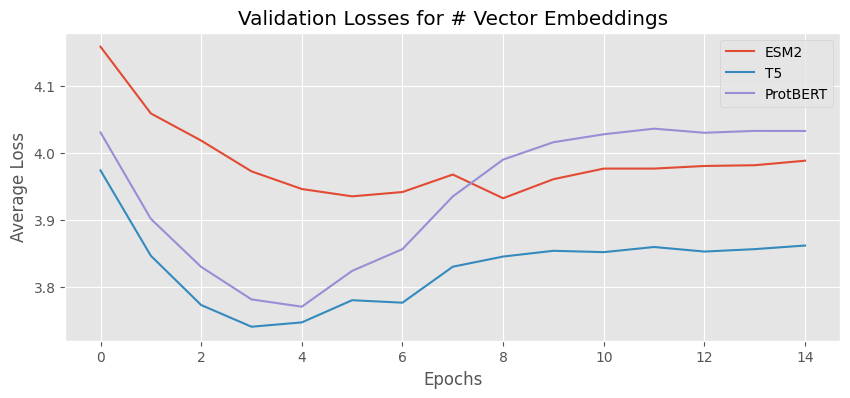

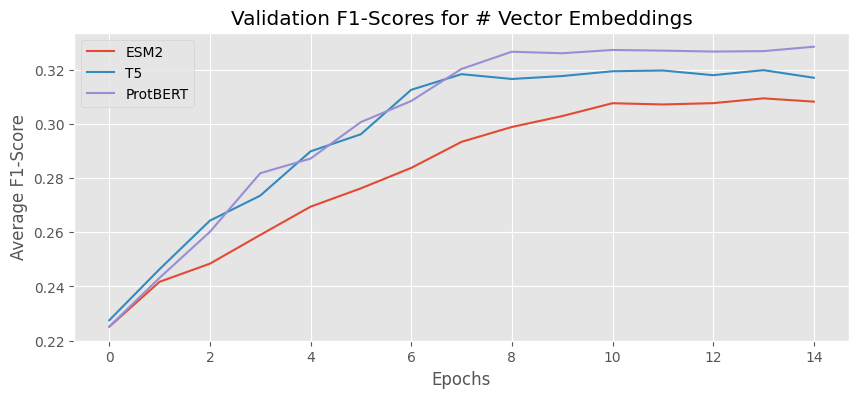

In [ ]:
plt.figure(figsize = (10, 4))
plt.plot(esm2_losses["val"], label = "ESM2")
plt.plot(t5_losses["val"], label = "T5")
plt.plot(protbert_losses["val"], label = "ProtBERT")
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
plt.plot(esm2_scores["val"], label = "ESM2")
plt.plot(t5_scores["val"], label = "T5")
plt.plot(protbert_scores["val"], label = "ProtBERT")
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

## Make Predictions

In [ ]:
def predict(embeddings_source):

    test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = embeddings_source)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

    if embeddings_source == "T5":
        model = t5_model
    if embeddings_source == "ProtBERT":
        model = protbert_model
    if embeddings_source == "EMS2":
        model = esm2_model

    model.eval()

    labels = pd.read_csv(CFG.train_terms_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = [label.split('_')[-1] for label in label_cols]
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*CFG.num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*CFG.num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*CFG.num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(CFG.device)
        confs_[i*CFG.num_labels:(i+1)*CFG.num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*CFG.num_labels:(i+1)*CFG.num_labels] = id[0]
        go_terms_[i*CFG.num_labels:(i+1)*CFG.num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [ ]:
submission_df = predict("T5")

GENERATE PREDICTION FOR TEST SET...


141865it [01:39, 1428.83it/s]


PREDICTIONS DONE


In [ ]:
graph.nodes["GO:0005634"]

{'name': 'nucleus',
 'namespace': 'cellular_component',
 'def': '"A membrane-bounded organelle of eukaryotic cells in which chromosomes are housed and replicated. In most cells, the nucleus contains all of the cell\'s chromosomes except the organellar chromosomes, and is the site of RNA synthesis and processing. In some species, or in specialized cell types, RNA metabolism or DNA replication may be absent." [GOC:go_curators]',
 'subset': ['goslim_agr',
  'goslim_candida',
  'goslim_chembl',
  'goslim_drosophila',
  'goslim_flybase_ribbon',
  'goslim_generic',
  'goslim_metagenomics',
  'goslim_mouse',
  'goslim_pir',
  'goslim_plant',
  'goslim_yeast'],
 'synonym': ['"cell nucleus" EXACT []',
  '"horsetail nucleus" NARROW [GOC:al, GOC:mah, GOC:vw, PMID:15030757]'],
 'xref': ['NIF_Subcellular:sao1702920020', 'Wikipedia:Cell_nucleus'],
 'is_a': ['GO:0043231']}

In [ ]:
train_terms[(train_terms['EntryID'] == 'P62259') & (train_terms['aspect'] == 'CCO')]

,EntryID,term,aspect,ia
4023148,P62259,GO:0005829,CCO,1.545978
4023149,P62259,GO:0005622,CCO,0.366945
4023150,P62259,GO:0043229,CCO,0.017165
4023151,P62259,GO:0043226,CCO,0.584346
4023152,P62259,GO:0110165,CCO,0.025471
4023153,P62259,GO:0005739,CCO,2.045246
4023154,P62259,GO:0005737,CCO,0.412201
4023155,P62259,GO:0005575,CCO,0.000000
4023156,P62259,GO:0043227,CCO,0.134798
4023157,P62259,GO:0043231,CCO,0.029561


In [ ]:
graph.nodes["GO:0005829"]

{'name': 'cytosol',
 'namespace': 'cellular_component',
 'def': '"The part of the cytoplasm that does not contain organelles but which does contain other particulate matter, such as protein complexes." [GOC:hjd, GOC:jl]',
 'subset': ['goslim_agr',
  'goslim_chembl',
  'goslim_drosophila',
  'goslim_flybase_ribbon',
  'goslim_generic',
  'goslim_mouse',
  'goslim_plant'],
 'xref': ['NIF_Subcellular:sao101633890', 'Wikipedia:Cytosol'],
 'is_a': ['GO:0110165'],
 'relationship': ['part_of GO:0005737']}

In [ ]:
print(len(submission_df))
submission_df[submission_df['Id'] == 'P62259']

4114085


,Id,GO term,Confidence
29,P62259,GO:0005615,0.111049
30,P62259,GO:0005634,0.656699
31,P62259,GO:0005654,0.441166
32,P62259,GO:0005730,0.015628
33,P62259,GO:0005737,0.329403
34,P62259,GO:0005739,0.464971
35,P62259,GO:0005783,0.032017
36,P62259,GO:0005794,0.314478
37,P62259,GO:0005815,0.348605
38,P62259,GO:0005829,0.869352


In [ ]:
submission_df.to_csv('submission.tsv', sep='\t', index=False)